## Experimentation with Transformer Architecture for Stock Time Series Forecasting

In [1]:
import torch
import torch.optim as optim
import os
from argparse import Namespace
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from time_series_transformer import TimeSeriesGPT, TimeSeriesTransformer
from stocks import StockDatasetGPT, StockDataset
from stock_transformer_trainer import StockTransformerTrainer

%matplotlib inline

In [13]:
# some utility functions

def forecast_and_plot(model, dataset, split, src_cols, tgt_cols, args):
    dataset.set_split(split)
    x_source = np.zeros((len(dataset)+args.lookback_window, len(src_cols)))
    pred = np.zeros((len(dataset)+args.lookback_window+args.forward_window, len(tgt_cols)))
    # generate input one at a time and no shuffle to keep the time order
    batch_generator = dataset.generate_batches(dataset, batch_size=1, shuffle=False, device=args.device)
    for batch_index, batch_dict in enumerate(batch_generator):
        x_input = batch_dict['x_source']
        y_input = batch_dict['y_input']
        y_target = batch_dict['y_target']
        # forecast
        x_out = model.forecast(x_source=x_input, target_seed=y_input[:, 0, :].unsqueeze(1))
        x_source[batch_index:batch_index+args.lookback_window, :] = x_input.detach().cpu().numpy()
        pred[batch_index+args.lookback_window:batch_index+args.lookback_window+args.forward_window] = \
            x_out.detach().cpu().numpy()
    
    x_source_transformed = dataset.inverse_transform(src_cols, x_source)
    pred_transformed = dataset.inverse_transform(tgt_cols, pred)

    # fill np.nan for plotting purpose
    x_source[-args.forward_window:, :] = np.nan
    pred[-args.forward_window+1:, :] = np.nan
    pred[:args.lookback_window, :] = np.nan
    x_source_transformed[-args.forward_window:, :] = np.nan
    pred_transformed[-args.forward_window+1:, :] = np.nan
    pred_transformed[:args.lookback_window, :] = np.nan
    
    for i in range(len(tgt_cols)):
        plt.figure(figsize=(10, 5))
        plt.title(tgt_cols[i])
        plt.plot(x_source_transformed[:, i], label='history')
        plt.plot(pred_transformed[:, i], label='prediction')
        plt.legend(loc="upper left")

    return x_source_transformed, pred_transformed, x_source, pred
    

### Model Training
Use a deep encoder (12 layers) and shallow decoder (4 layers) strucutre. Other parameters should be tuned and selection critria needs to be developed to select parameter sets

In [5]:
args = Namespace(dataset_csv="sector_etf.csv",
                 model_state_file="transform_ts_model.pth",
                 save_dir="model_storage/stock/",
                 reload_from_files=True,
                 expand_filepaths_to_save_dir=True,
                 cuda=True,
                 seed=1337,
                 learning_rate=1e-3,
                 batch_size=64,
                 num_epochs=20,
                 num_encoder_layer=12,
                 num_decoder_layer=4,
                 num_attn_heads=4,
                 model_size=64,
                 dropout=0.2,
                 early_stopping_criteria=10,
                 forward_window=5,
                 lookback_window=40,
                 sequence_length=10,
                 catch_keyboard_interrupt=True)

if args.expand_filepaths_to_save_dir:
    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)
    print("Expanded filepaths: ")
    print("\t{}".format(args.model_state_file))

# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

args.device = torch.device("cuda" if args.cuda else "cpu")
print("Using CUDA: {}".format(args.cuda))

Expanded filepaths: 
	model_storage/stock/transform_ts_model.pth
Using CUDA: True


In [6]:
src_cols = ['XLF', 'XLB', 'XLE', 'XLK']
tgt_cols = ['XLF', 'XLB', 'XLE', 'XLK']

df = pd.read_csv(args.dataset_csv)
dataset = StockDataset(df,
                       lookback_window=args.lookback_window,
                       forward_window=args.forward_window,
                       src_cols=src_cols,
                       tgt_cols=tgt_cols)

model = TimeSeriesTransformer(input_size=len(src_cols),
                              model_size=args.model_size,
                              output_size=len(tgt_cols),
                              num_encoder=args.num_encoder_layer,
                              num_decoder=args.num_decoder_layer,
                              encoder_dropout=args.dropout,
                              decoder_dropout=args.dropout,
                              encoder_num_attn_heads=args.num_attn_heads,
                              decoder_num_attn_heads=args.num_attn_heads,
                              forward_window=args.forward_window)

optimizer = optim.AdamW(model.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                 mode='min', factor=0.5,
                                                 patience=1)

trainer = StockTransformerTrainer(model, optimizer, scheduler)
# Set seed for reproducibility
trainer.set_seed_everywhere(args.seed, args.cuda)
trainer.handle_dirs(args.save_dir)

train_state = trainer.train(dataset=dataset, args=args)
print("training finished: ", train_state)

training routine:   0%|          | 0/20 [00:00<?, ?it/s]

split=train:   0%|          | 0/69 [00:00<?, ?it/s]

split=val:   0%|          | 0/12 [00:00<?, ?it/s]

training finished:  {'stop_early': False, 'early_stopping_step': 0, 'early_stopping_best_val': 0.04104027431458235, 'learning_rate': 0.001, 'epoch_index': 19, 'train_loss': [0.11723660305142403, 0.02410964604359174, 0.0151439976837972, 0.011574930970327578, 0.01005965024502813, 0.008952978640740765, 0.007626031579422778, 0.007259754092850979, 0.006720994504681532, 0.006585566529437252, 0.006407259511288958, 0.006235834244854641, 0.0061266919786947364, 0.005997925288165393, 0.00585506811225112, 0.005839143157599197, 0.005760775055682314, 0.005770618845101284, 0.005782828234352063, 0.005776797596743141], 'train_acc': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'val_loss': [0.0522685864319404, 0.04749357979744673, 0.04755233352382978, 0.04207218096901973, 0.04509257090588411, 0.04564163492371639, 0.047917572781443596, 0.04279860543708006, 0.04200671426951885, 0.04104027431458235, 0.04347965338577827, 0.04328090821703275, 0.04297747

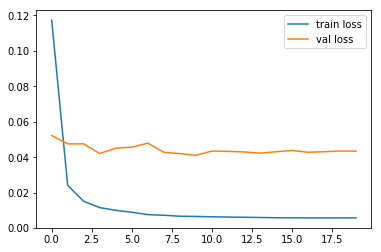

In [7]:
# plot loss
plt.plot(train_state['train_loss'], label='train loss')
plt.plot(train_state['val_loss'], label='val loss')
plt.legend(loc="upper right")

### Model Prediction - Plot historical data vs. one-day forecast. 
Visually the one-day forecast tracks the shape ok but feels more like a moving average on test set (1/1/2020 - 8/31/2021), validation set (10/1/2016 - 12/31/2019). One-day forecast seems to be lagging the real time series which is not good.

In [8]:
# load best model by loss
model.load_state_dict(torch.load(args.model_state_file))

<All keys matched successfully>

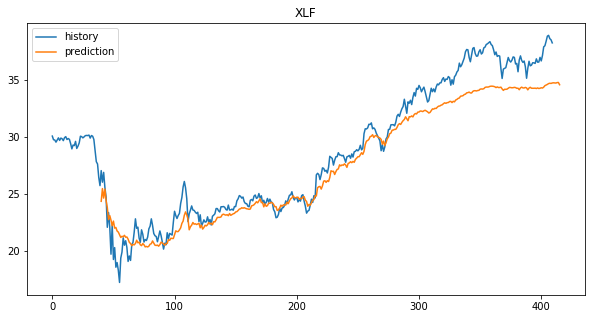

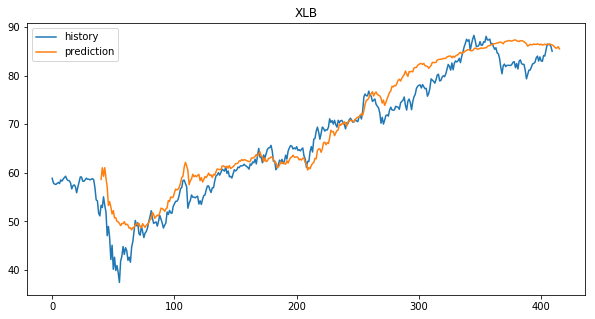

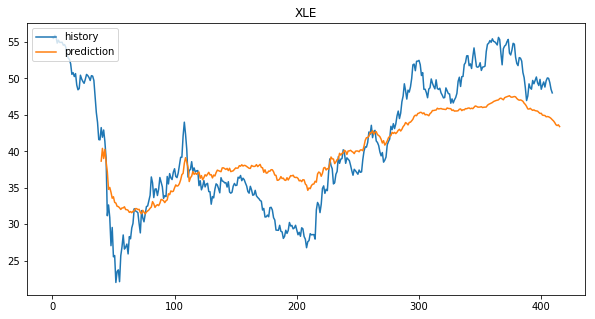

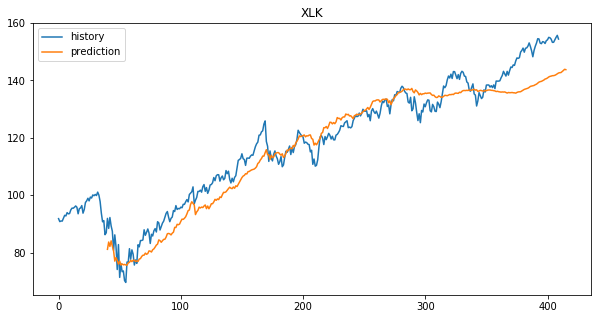

In [14]:
x_source_test, pred_test, _, _ = forecast_and_plot(model, dataset, 'test', src_cols, tgt_cols, args)

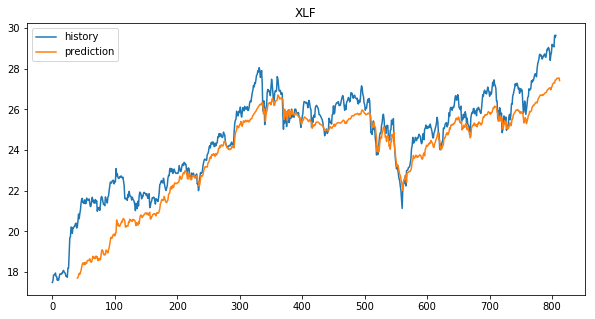

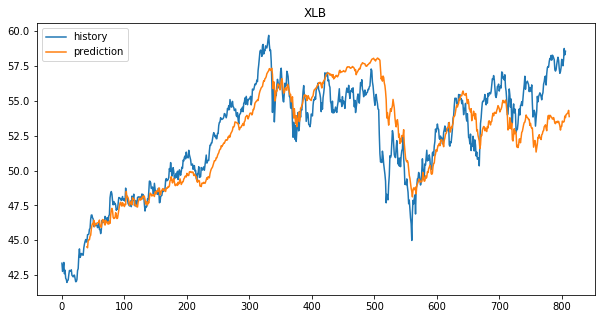

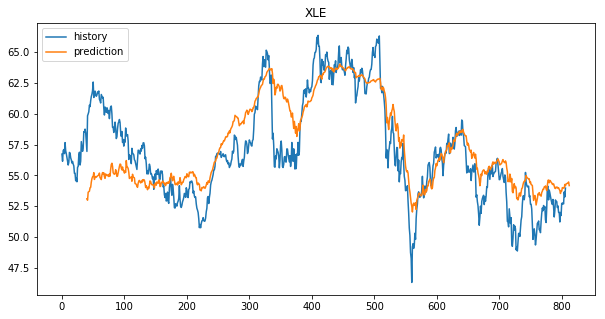

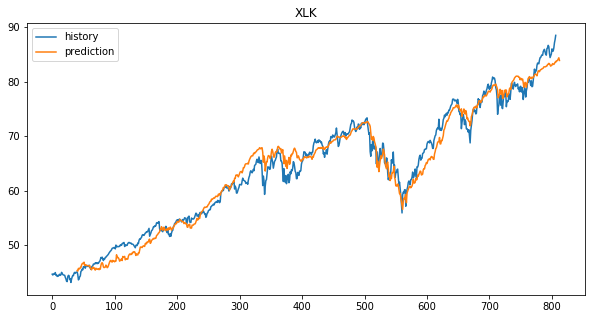

In [15]:
x_source_val, pred_val, _, _ = forecast_and_plot(model, dataset, 'val', src_cols, tgt_cols, args)

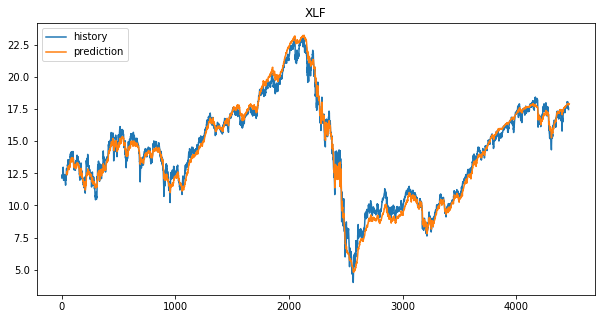

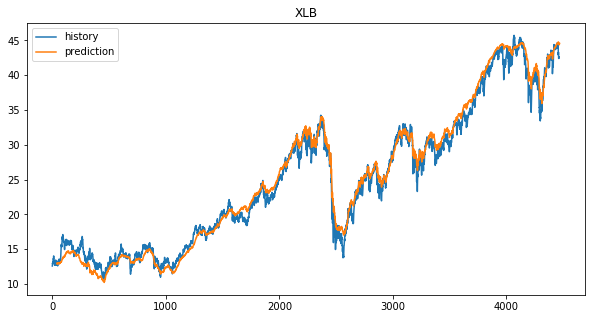

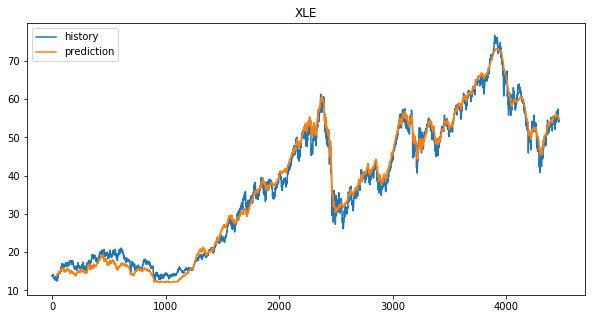

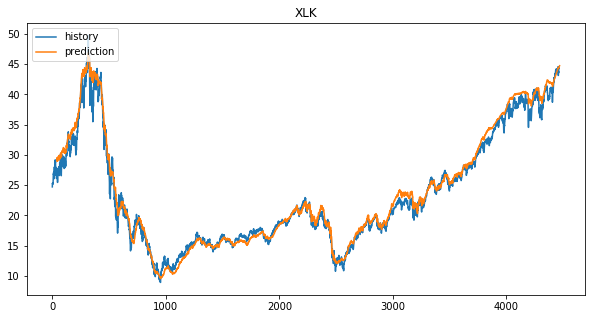

In [16]:
x_source_train, pred_train, _, _ = forecast_and_plot(model, dataset, 'train', src_cols, tgt_cols, args)

#### Experiments with shallow or deep layer
Use 12 decoder layers with other paramaters the same. The forecast is smoother which looks more like moving average. Less decoder layer is probably better.

In [17]:
# let's reuse old args
args.model_state_file = os.path.join(args.save_dir, "transform_ts_deep_model.pth")
args.num_decoder_layer=12

model2 = TimeSeriesTransformer(input_size=len(src_cols),
                               model_size=args.model_size,
                               output_size=len(tgt_cols),
                               num_encoder=args.num_encoder_layer,
                               num_decoder=args.num_decoder_layer,
                               encoder_dropout=args.dropout,
                               decoder_dropout=args.dropout,
                               encoder_num_attn_heads=args.num_attn_heads,
                               decoder_num_attn_heads=args.num_attn_heads,
                               forward_window=args.forward_window)

optimizer2 = optim.AdamW(model2.parameters(), lr=args.learning_rate)
scheduler2 = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                 mode='min', factor=0.5,
                                                 patience=1)

trainer2 = StockTransformerTrainer(model2, optimizer2, scheduler2)
# Set seed for reproducibility
trainer2.set_seed_everywhere(args.seed, args.cuda)
trainer2.handle_dirs(args.save_dir)

print(f"Traing transformer with {args.num_encoder_layer} encoder layers and {args.num_decoder_layer} decoder layers")
train_state = trainer2.train(dataset=dataset, args=args)

Traing transformer with 12 encoder layers and 12 decoder layers


training routine:   0%|          | 0/20 [00:00<?, ?it/s]

split=train:   0%|          | 0/69 [00:00<?, ?it/s]

split=val:   0%|          | 0/12 [00:00<?, ?it/s]

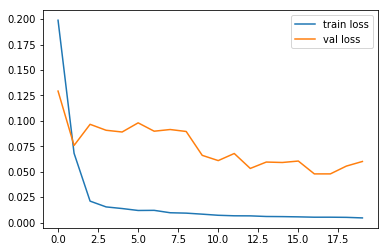

In [18]:
# plot loss
plt.plot(train_state['train_loss'], label='train loss')
plt.plot(train_state['val_loss'], label='val loss')
plt.legend(loc="upper right")

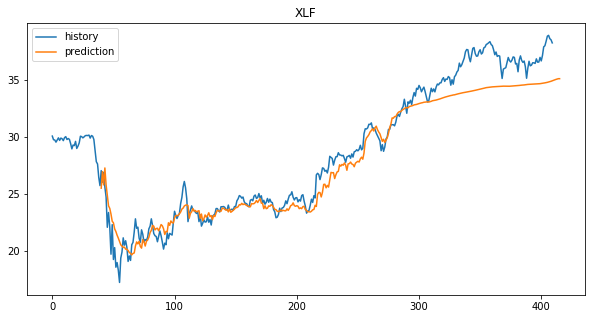

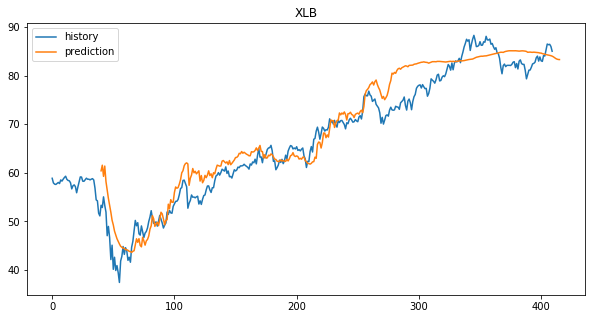

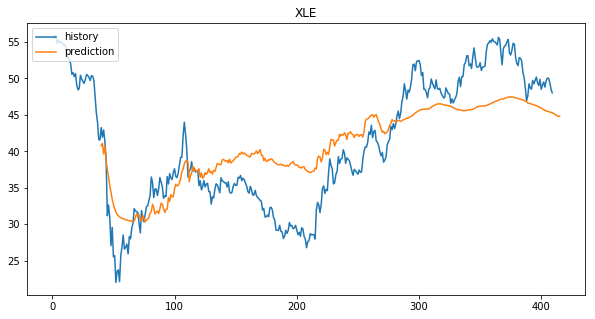

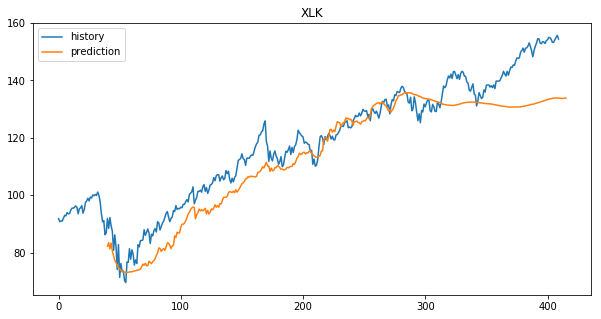

In [20]:
# load best model by loss
model2.load_state_dict(torch.load(args.model_state_file))
x_source_test, pred_test, _, _ = forecast_and_plot(model2, dataset, 'test', src_cols, tgt_cols, args)